# Предсказание характера отзыва. Логистическая регрессия.

Попробуем построить модель машинного обучения, которая будет по тексту отзыва угадывать -- это положительный или отрицательный отзыв. Такие модели могут быть полезны для анализа общественного мнения -- например, анализируя посты в соцсетях можно строить некоторые статистические характеристики и планировать поведение организации.
Отметим целевой категорией предсказания -- Not Recommended, чтобы сосредоточиться на поиске негативных отзывов.

In [1]:
from typing import Tuple

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

df_filename = './data/apex-legends-steam-reviews.csv'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anatolii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(df_filename)

In [3]:
df['Recommended'].value_counts()

Recommended
True     9346
False    5344
Name: count, dtype: int64

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Text'] = df['Text'].astype(str)
df['Recommended'] = df['Recommended'].apply(lambda x: not x).astype(int)
df = df.rename(columns={'Recommended': 'Not Recommended'})
df['Not Recommended'].value_counts()

Not Recommended
0    9346
1    5344
Name: count, dtype: int64

Применим TF-IDF преобразование и обучим модель для предсказания бинарного признака Recommended.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [6]:
X = df['Text']
y = df['Not Recommended']

In [7]:
y.value_counts()

Not Recommended
0    9346
1    5344
Name: count, dtype: int64

In [8]:
stop_words = set(stopwords.words('english'))


def tokenize(text: str):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    tokens = [t for t in text.split() if t not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]
    return tokens

def precision_recall_score(y_test, y_pred, console_print: bool = True) -> Tuple[float, float]:
    precision = precision_score(y_test, y_pred, )
    recall = recall_score(y_test, y_pred)
    if console_print:
        print(f'Precision: {precision} \nRecall: {recall}')
    return precision, recall

def plot_confusion_matrix(conf_matrix, figsize: Tuple[float, float] = (8, 8)) -> None:
    plt.subplots(figsize=figsize)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Recommended', 'Not Recommended'],
                yticklabels=['Recommended', 'Not Recommended'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_precision_recall_curve(precision, recall) -> None:
    plt.subplots(figsize=(8,8))
    plt.plot(recall, precision, marker='.')
    plt.grid(True, color='grey', linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=5000, token_pattern=None)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [10]:
y_train.value_counts(normalize=True)

Not Recommended
0    0.632914
1    0.367086
Name: proportion, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

Not Recommended
0    0.649421
1    0.350579
Name: proportion, dtype: float64

Соотношение классов примерно одинаково в выборках. Различие между самими классами не столь велико. Генерировать новые наблюдения не будем.

In [12]:
pipeline = Pipeline(steps=[
    ('vectorizer', vectorizer),
    ('model', LogisticRegression(random_state=37))
])

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=5000, token_pattern=None,
                                 tokenizer=<function tokenize at 0x7f35967091c0>)),
                ('model', LogisticRegression(random_state=37))])

In [14]:
y_pred = pipeline.predict(X_test)

In [15]:
precision_recall_score(y_test, y_pred);

Precision: 0.7840646651270208 
Recall: 0.6592233009708738


# s


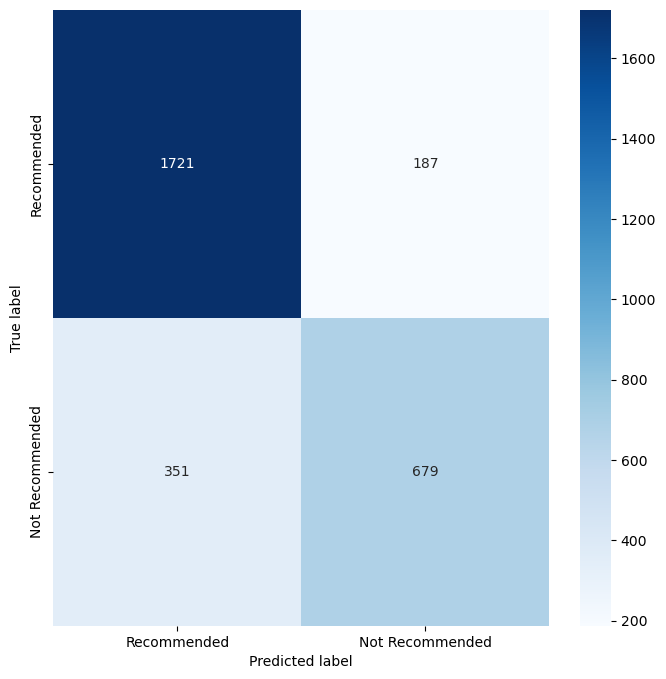

In [16]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

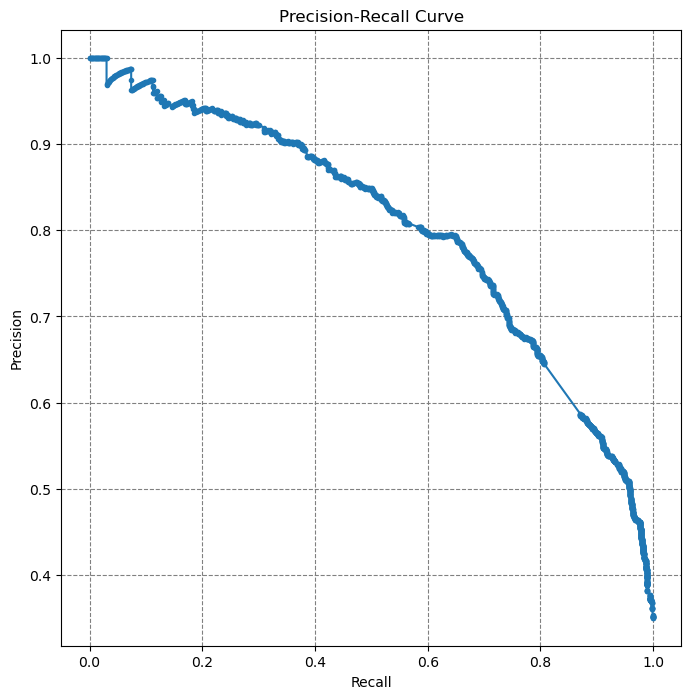

In [17]:
y_probas = pipeline.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_test, y_probas)
plot_precision_recall_curve(precision_curve, recall_curve)

Попробуем покрутить гиперпараметры. Наша цель -- определять лучше негативные комментарии, пусть и с ложно положительными, поэтому будем увеличивать recall.
Попробуем поменять гиперпараметры, чтобы увеличить точность модели.

In [18]:
grid_params = {
    'vectorizer__max_features': list(range(4000, 20000+1, 2000)),
    'model__C': list(map(float, np.linspace(0.1, 0.9, 9))) + list(range(1, 10 + 1))
}

In [19]:
model = GridSearchCV(pipeline, param_grid=grid_params, cv=5, verbose=1, n_jobs=-1)

In [20]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 171 candidates, totalling 855 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=5000,
                                                        token_pattern=None,
                                                        tokenizer=<function tokenize at 0x7f35967091c0>)),
                                       ('model',
                                        LogisticRegression(random_state=37))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                      0.6, 0.7000000000000001, 0.8, 0.9, 1, 2,
                                      3, 4, 5, 6, 7, 8, 9, 10],
                         'vectorizer__max_features': [4000, 6000, 8000, 10000,
                                                      12000, 14000, 16000,
                                                      18000, 20000]},
             verbose=1)

In [21]:
y_pred = model.predict(X_test)

In [22]:
precision_recall_score(y_test, y_pred);

Precision: 0.7878787878787878 
Recall: 0.6563106796116505


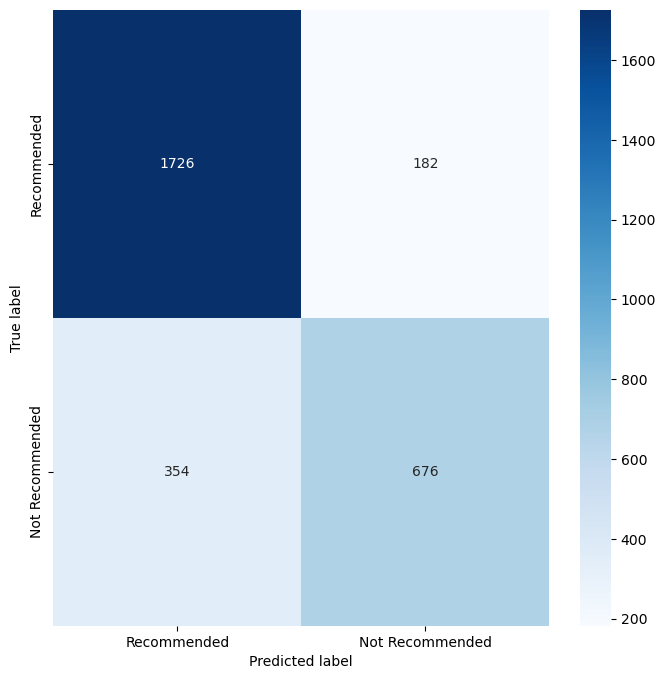

In [23]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

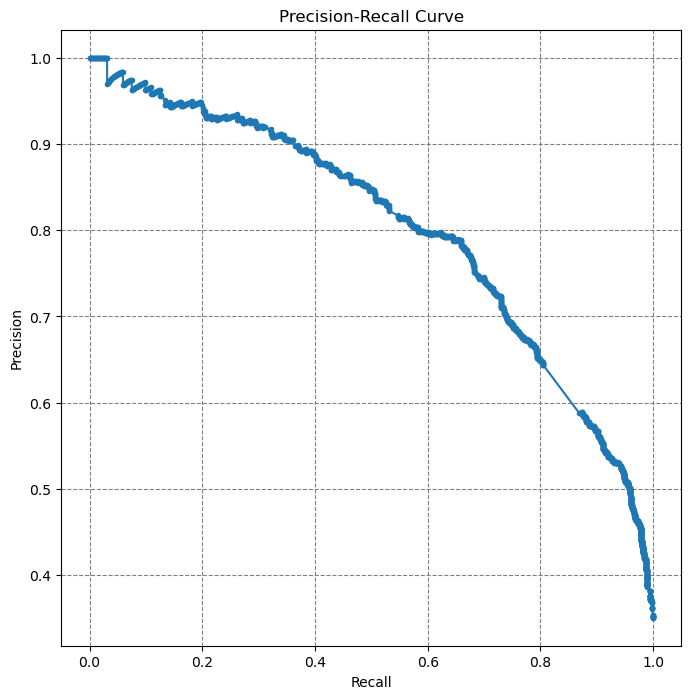

In [24]:
y_probas = model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_test, y_probas)

plot_precision_recall_curve(precision_curve, recall_curve)

In [25]:
model.best_estimator_

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=6000, token_pattern=None,
                                 tokenizer=<function tokenize at 0x7f35967091c0>)),
                ('model', LogisticRegression(C=1, random_state=37))])

Пострим еще ROC кривую

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas)

roc_auc = roc_auc_score(y_test, y_probas)

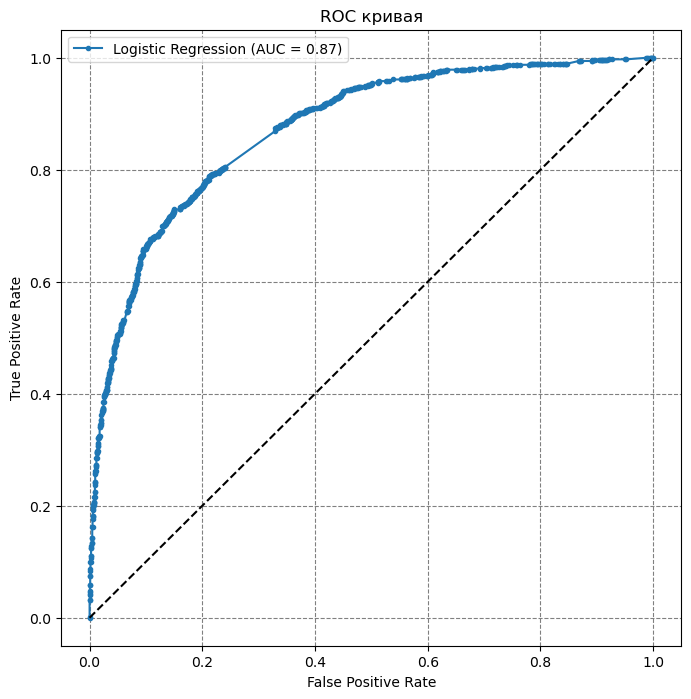

In [27]:
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, marker='.', label=f'Logistic Regression (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.grid(True, color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend()
plt.show()

Выберем финальное значение порога по кривой precision-recall.

In [28]:
np.where(recall_curve > .95)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [29]:
threshold = thresholds_curve[np.where(recall_curve > .95)[0][-1]] # Оптимум

In [30]:
precision_recall_score(y_test, y_probas > threshold);

Precision: 0.5096404377279833 
Recall: 0.9495145631067962


В результате получилась модель, которая с 95% вероятностью определяет истинно отзыв НЕ рекомендательный, но в половине может ошибаться.